# Used Cars Dataset

The Dataset can be found [here](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)

## Loading Packages and Dataset

In [143]:
import pandas as pd
import numpy as np
from numpy import mean

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from tabulate import tabulate


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer

#sns.set(rc={'figure.figsize':(11.7,8.27)})
import geopandas

In [144]:
col_list = ['region', 'state', 'price', 'year', 'manufacturer', 'model', 'condition',
            'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', "lat", "long",
            'drive', 'type']

schema = {'region':"category", 'state':"category",'price':"int64", 'year':"float32",  'manufacturer':"category", 'model':"str", 
          'condition':"category",'cylinders':"category", 'fuel':"category", 'odometer':"float32", 'title_status':"category", 
          'transmission':"category", 'drive':"category", 'type':"category"}

df_initial = pd.read_csv("./vehicles.csv", usecols=col_list, dtype=schema)

In [145]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        426880 non-null  category
 1   price         426880 non-null  int64   
 2   year          425675 non-null  float32 
 3   manufacturer  409234 non-null  category
 4   model         421603 non-null  object  
 5   condition     252776 non-null  category
 6   cylinders     249202 non-null  category
 7   fuel          423867 non-null  category
 8   odometer      422480 non-null  float32 
 9   title_status  418638 non-null  category
 10  transmission  424324 non-null  category
 11  drive         296313 non-null  category
 12  type          334022 non-null  category
 13  state         426880 non-null  category
 14  lat           420331 non-null  float64 
 15  long          420331 non-null  float64 
dtypes: category(10), float32(2), float64(2), int64(1), object(1)
memory usage:

In [146]:
df_initial.sample()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,state,lat,long
398232,roanoke,28590,2017.0,ram,1500 quad cab express pickup,good,NaN,other,41816.0,clean,other,4wd,pickup,va,37.27,-79.95


In [147]:
df_initial.shape

(426880, 16)

## Preprocessing and cleaning the Data

In [148]:
def missing_values(df):
    return (df.isnull().sum()*100 /len(df)).sort_values(ascending=False)
    

In [149]:
df1 = df_initial.copy(deep=True)

In [150]:
df1.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,state,lat,long
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN
5,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN
6,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN
7,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN
8,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN
9,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa,NaN,NaN


In [151]:
missing_values(df1)

cylinders       41.622470
condition       40.785232
drive           30.586347
type            21.752717
manufacturer     4.133714
title_status     1.930753
lat              1.534155
long             1.534155
model            1.236179
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
region           0.000000
price            0.000000
state            0.000000
dtype: float64

In [152]:
df1.shape

(426880, 16)

In [153]:
df1.describe([0.01, 0.25, 0.5, 0.75, 0.99])

,price,year,odometer,lat,long
count,4.268800e+05,425675.000000,4.224800e+05,420331.000000,420331.000000
mean,7.519903e+04,2009.413696,9.804179e+04,38.493940,-94.748599
std,1.218228e+07,9.626303,2.138404e+05,5.841533,18.365462
min,0.000000e+00,1900.000000,0.000000e+00,-84.122245,-159.827728
1%,0.000000e+00,1967.000000,2.000000e+00,25.844662,-149.869094
25%,5.900000e+03,2008.000000,3.770400e+04,34.601900,-111.939847
50%,1.395000e+04,2013.000000,8.554800e+04,39.150100,-88.432600
75%,2.648575e+04,2017.000000,1.335425e+05,42.398900,-80.832039
99%,6.699500e+04,2020.000000,2.800000e+05,48.754959,-71.081834
max,3.736929e+09,2022.000000,1.000000e+07,82.390818,173.885502


### First look

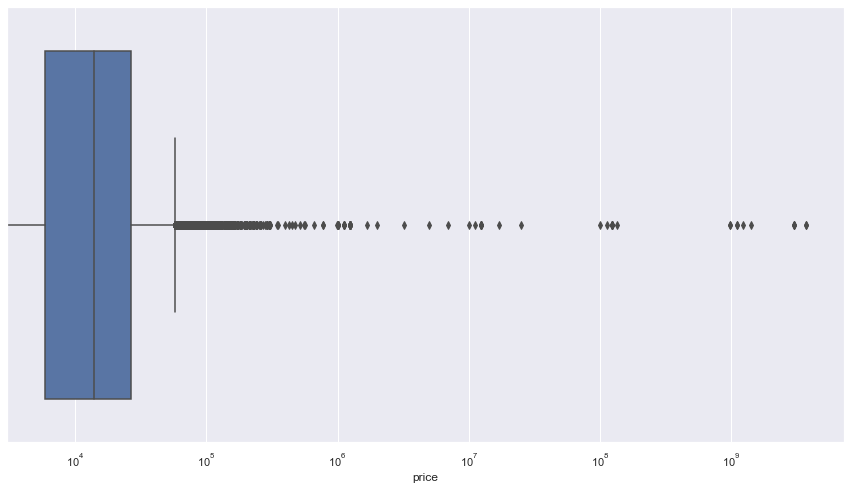

In [154]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x=df1["price"], orient="h")
ax.set_xscale('log')

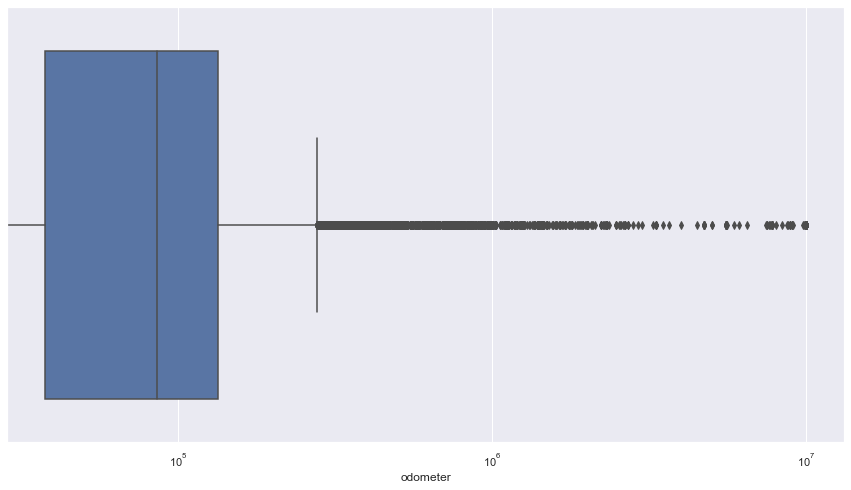

In [155]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x=df1["odometer"], orient="h")
ax.set_xscale('log')

In [156]:
df1[df1["price"] == 0]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,state,lat,long
10,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx,NaN,NaN
11,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx,NaN,NaN
12,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx,NaN,NaN
13,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx,NaN,NaN
14,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426764,wyoming,0,2018.0,NaN,peterbilt 579,NaN,NaN,diesel,1.0,clean,automatic,NaN,NaN,wy,42.862274,-106.307144
426812,wyoming,0,2006.0,toyota,scion tc,excellent,4 cylinders,gas,195000.0,clean,automatic,fwd,NaN,wy,40.114685,-104.971971
426832,wyoming,0,2004.0,toyota,prius,excellent,4 cylinders,hybrid,239000.0,clean,automatic,fwd,NaN,wy,40.114685,-104.971971
426836,wyoming,0,2018.0,ram,2500,excellent,6 cylinders,diesel,20492.0,clean,automatic,4wd,truck,wy,45.082436,-94.334686


In [157]:
df1[df1["price"] < 10].shape

(34929, 16)

In [158]:
df1[df1["price"] < 100].shape

(36222, 16)

In [159]:
# Since the dataset does not give an explain of why some cars are listed for zero and the cars seem to be in good shape, I will
# drop all these entries plus all entries with prices less than 100, because they could bias the results. 
print(" Number of cars which are listed for less than $100 is {} however the majority {} are listed for less than $10 \n {} Cars are listed for more than $100k"
      .format(len(df1[df1.price <100]), len(df1[df1.price <10]),
              len(df1[df1.price >100000])
             )
     ) 
print("\n Cars with odometers values larger than 300k", len(df1[df1.odometer >300000]))

 Number of cars which are listed for less than $100 is 36222 however the majority 34929 are listed for less than $10 
 655 Cars are listed for more than $100k

 Cars with odometers values larger than 300k 3032


In [160]:
to_drop = df1[(df1.price <100)|(df1.price >100000)|(df1.odometer >300000)].index

In [161]:
print("Dropping %.2f percent of the entries to eliminate outliers" %((len(to_drop)/df1.shape[0])*100))


Dropping 9.28 percent of the entries to eliminate outliers


In [162]:
df1.drop(to_drop, axis=0, inplace=True)
df1.dropna(subset = ["model", "year", "odometer"], inplace=True)

In [163]:
df1.shape

(379542, 16)

In [164]:
def models_dist(df):
    
    models = df.groupby("model")["region"].count().reset_index()\
                     .rename(columns={"region":"count"}).sort_values("count")

    models["quintile"] = 1/len(models)*100
    models["quintile (cum)"] = models["quintile"].cumsum()

    models["share of total"] = (models["count"]/sum(models["count"]))*100
    models["share of total (cum)"] = models["share of total"].cumsum()

    models.drop(columns=["quintile", "share of total"], inplace=True)
    return models

In [165]:
def models_plot(df):
    plt.figure(figsize = (15,8))
    plt.plot( df["quintile (cum)"], df["share of total (cum)"])
    plt.fill_between(df["quintile (cum)"], df["share of total (cum)"])
    plt.title('Distribution of car models', fontsize=20)
    plt.ylabel('Cummulative Share', fontsize=15)
    plt.xlabel('Model Quintiles', fontsize=15)
    plt.show()

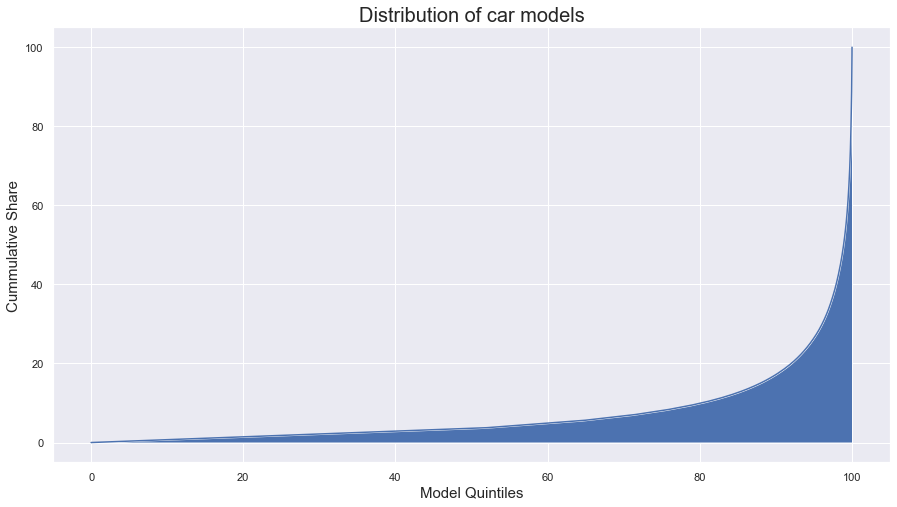

In [166]:
models_plot(models_dist(df1))

In [167]:
models = df1.groupby("model")["region"].count().reset_index()\
                 .rename(columns={"region":"count"}).sort_values("count")

models["quintile"] = 1/len(models)*100
models["quintile (cum)"] = models["quintile"].cumsum()

models["share of total"] = (models["count"]/sum(models["count"]))*100
models["share of total (cum)"] = models["share of total"].cumsum()

models.drop(columns=["quintile", "share of total"], inplace=True)

models.head(10)

,model,count,quintile (cum),share of total (cum)
0,"$362.47, $1000 down, oac, 2.9%apr $362.47,luxu...",1,0.003677,0.000263
14659,flex limited w/ecoboost,1,0.007354,0.000527
14660,flex ltd.,1,0.011031,0.000790
14664,flex secrossover,1,0.014708,0.001054
14666,flex sel 118k awd new tires 3rd row 118k 23mpg,1,0.018385,0.001317
14668,flex sel automatic,1,0.022062,0.001581
14670,flex sel fwd,1,0.025739,0.001844
14671,flex sel is,1,0.029416,0.002108
14673,flex sel sport – 3rd row,1,0.033093,0.002371
14674,flex sel wagon,1,0.036770,0.002635


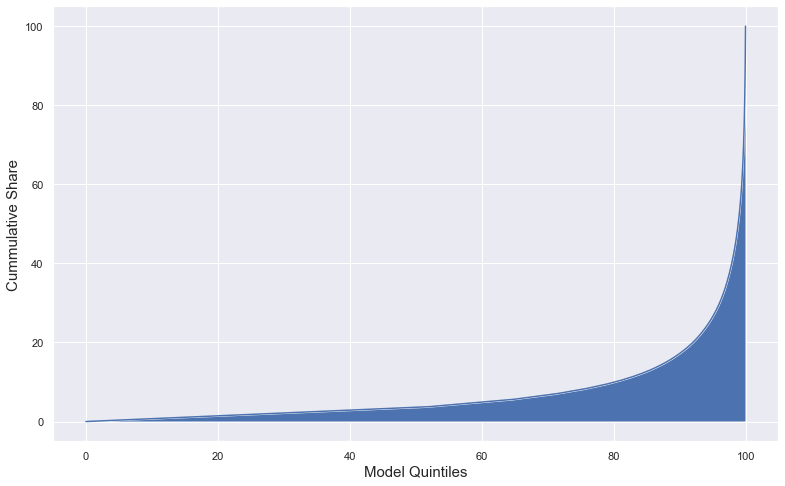

In [168]:
plt.plot( models["quintile (cum)"], models["share of total (cum)"])
plt.fill_between(models["quintile (cum)"], models["share of total (cum)"])
#plt.title('Gini: {}'.format(gini), fontsize=20)
plt.ylabel('Cummulative Share', fontsize=15)
plt.xlabel('Model Quintiles', fontsize=15)
plt.show()

#px.line(models, x="quintile (cum)", y="share of total (cum)")

In [169]:
models[models["count"] ==1].sort_values("share of total (cum)", ascending=False)

,model,count,quintile (cum),share of total (cum)
8573,c30 fire truck,1,51.614208,3.698405
6608,a 4,1,51.610531,3.698141
6637,a3 3.2 quattro sline,1,51.606854,3.697878
6523,WVWWF7AU5HW191345,1,51.603177,3.697614
8590,c300 c-300 luxury awd,1,51.599500,3.697351
...,...,...,...,...
14666,flex sel 118k awd new tires 3rd row 118k 23mpg,1,0.018385,0.001317
14664,flex secrossover,1,0.014708,0.001054
14660,flex ltd.,1,0.011031,0.000790
14659,flex limited w/ecoboost,1,0.007354,0.000527


**More than 50% of the total car models have only one entry and account for only 3.7% of the total entries**

In [170]:
models[models["count"] <10].sort_values("share of total (cum)", ascending=False)

,model,count,quintile (cum),share of total (cum)
18393,mirage le cvt,9,85.019856,12.651301
20244,q5 2.0t premium plus,9,85.016179,12.648929
16059,gx 470 4dr suv,9,85.012502,12.646558
8636,c5500 topkick,9,85.008825,12.644187
11798,econoline e150 cargo van,9,85.005148,12.641816
...,...,...,...,...
14666,flex sel 118k awd new tires 3rd row 118k 23mpg,1,0.018385,0.001317
14664,flex secrossover,1,0.014708,0.001054
14660,flex ltd.,1,0.011031,0.000790
14659,flex limited w/ecoboost,1,0.007354,0.000527


In [171]:
# Since I will be splitting the data using a 80/20 split, the train dataset should at least have one entry, 
# hence the car model should have at least 5 entries. However in order to be sure, I will drop all models with entries less 
# than 10
drop_models = models[models["count"] <10]["model"]
df1 = df1[~df1["model"].isin(drop_models)]
df1.shape

(331525, 16)

### Handling missing values

In [172]:
missing_values(df1)

cylinders       41.842998
condition       38.586834
drive           30.624236
type            21.025262
manufacturer     1.903929
title_status     1.282860
lat              0.957997
long             0.957997
transmission     0.421084
fuel             0.246739
region           0.000000
price            0.000000
year             0.000000
model            0.000000
odometer         0.000000
state            0.000000
dtype: float64

In [173]:
# Getting the values for the same model from other rows.

cols = ["cylinders", "drive", "type", "manufacturer", "fuel", "transmission"]


for col in cols:
    df11 = df1[df1[col].notna()].copy(deep = True)
    dict_ = {}
    for k, v in df11[['model', col]].values:
        dict_[k] = v
        
    df1[col] = df1.apply( lambda x: x[col] if pd.notna( x[col] )
                                        else dict_[x['model']] if x['model'] in dict_.keys() 
                                        else x[col], axis=1)

del df11, dict_

In [174]:
missing_values(df1)

condition       38.586834
cylinders        7.376518
drive            3.771963
manufacturer     1.750396
title_status     1.282860
lat              0.957997
long             0.957997
type             0.711259
fuel             0.065153
region           0.000000
price            0.000000
year             0.000000
model            0.000000
odometer         0.000000
transmission     0.000000
state            0.000000
dtype: float64

In [175]:
df1.dropna(subset = ["fuel", "type", "title_status", "lat", "long", "manufacturer", "drive", "cylinders"], inplace=True)

In [176]:
df1.drop_duplicates(keep = "first", inplace = True)

In [177]:
missing_values(df1)

condition       38.217822
region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
model            0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
drive            0.000000
type             0.000000
state            0.000000
lat              0.000000
long             0.000000
dtype: float64

In [178]:
models_keep = df1[df1["condition"].notna()]["model"].unique()
df1[~df1["model"].isin(models_keep)].shape[0]/df1.shape[0]*100

0.6942574257425742

In [179]:
df_clean = df1[df1["model"].isin(models_keep)].sort_values(["model", "odometer", "price", "year"])

In [180]:
df_clean["condition"].unique()

['excellent', 'like new', NaN, 'good', 'fair', 'new', 'salvage']
Categories (6, object): ['excellent', 'fair', 'good', 'like new', 'new', 'salvage']

In [181]:
df_clean["condition"].replace(['new', 'like new', 'excellent', 'good', 'fair','salvage'], [1, 2, 3, 4, 5, 6], inplace=True)
df_clean["condition"] = pd.to_numeric(df_clean["condition"])

In [182]:
df_clean.groupby("condition")["region"].count()

condition
1.0      660
2.0    13780
3.0    60928
4.0    75535
5.0     4681
6.0      416
Name: region, dtype: int64

In [183]:
df_clean.fillna(method="ffill").groupby("condition")["region"].count()

condition
1.0      1503
2.0     26178
3.0    112257
4.0    102359
5.0      7666
6.0       784
Name: region, dtype: int64

In [184]:
imputer = KNNImputer(n_neighbors=10)
imputed_cond = []

for model in df_clean["model"].unique().tolist():
    col = df_clean[df_clean["model"] ==model]
    imputed_cond.append(imputer.fit_transform(col[["condition"]]))
    
df_clean["condition"] = np.concatenate(imputed_cond, axis = 0)
df_clean["condition"] = round(df_clean["condition"], 0)  

In [185]:
df_clean.groupby("condition")["region"].count()

condition
1.0       674
2.0     14400
3.0    146016
4.0     84435
5.0      4709
6.0       513
Name: region, dtype: int64

In [186]:
df_clean.duplicated().sum()

20

In [187]:
df_clean.drop_duplicates(keep="first", inplace=True)

In [188]:
missing_values(df_clean)

region          0.0
price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
state           0.0
lat             0.0
long            0.0
dtype: float64

In [189]:
df1.shape

(252500, 16)

## Further Cleaning and Visualization

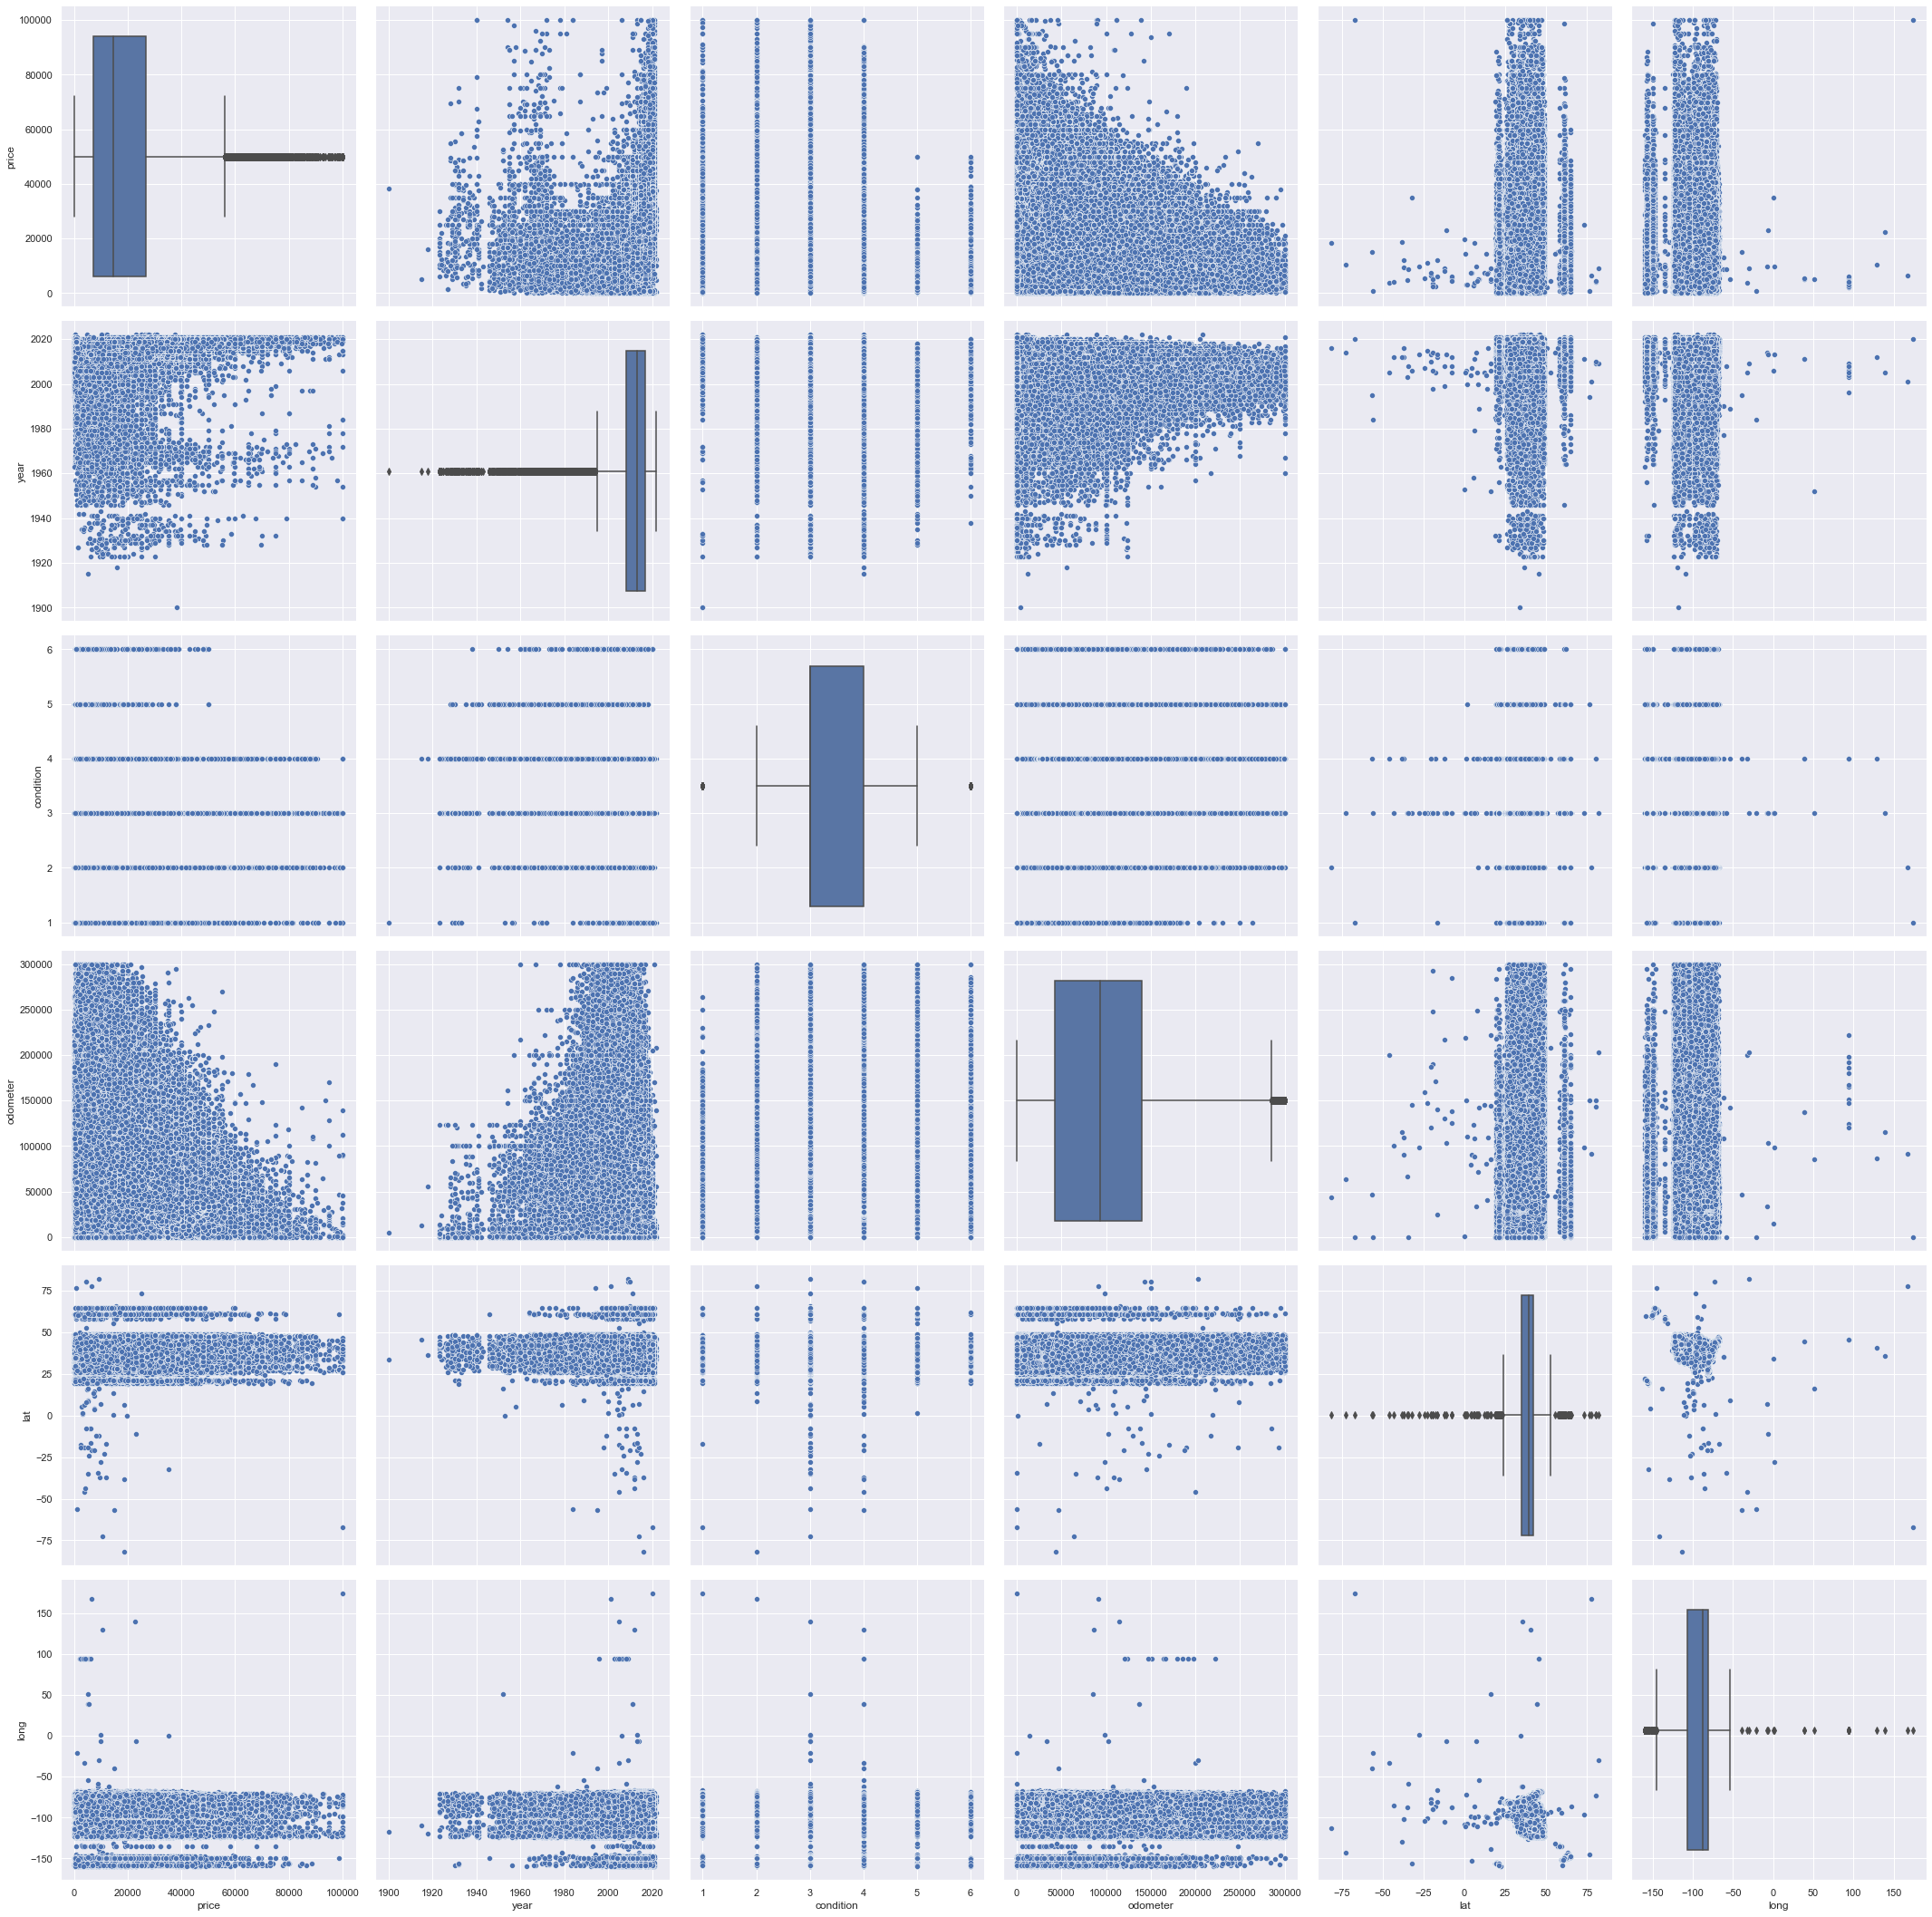

In [190]:
g = sns.PairGrid(df_clean, height=5)
g.map_diag(sns.boxplot)
g.map_offdiag(sns.scatterplot)

In [191]:
drop_years = df_clean[(df_clean["year"] <1996) | (df_clean["price"] > 55000) | (df_clean["odometer"] >280000)].index
df_clean.drop(drop_years, axis=0, inplace=True)

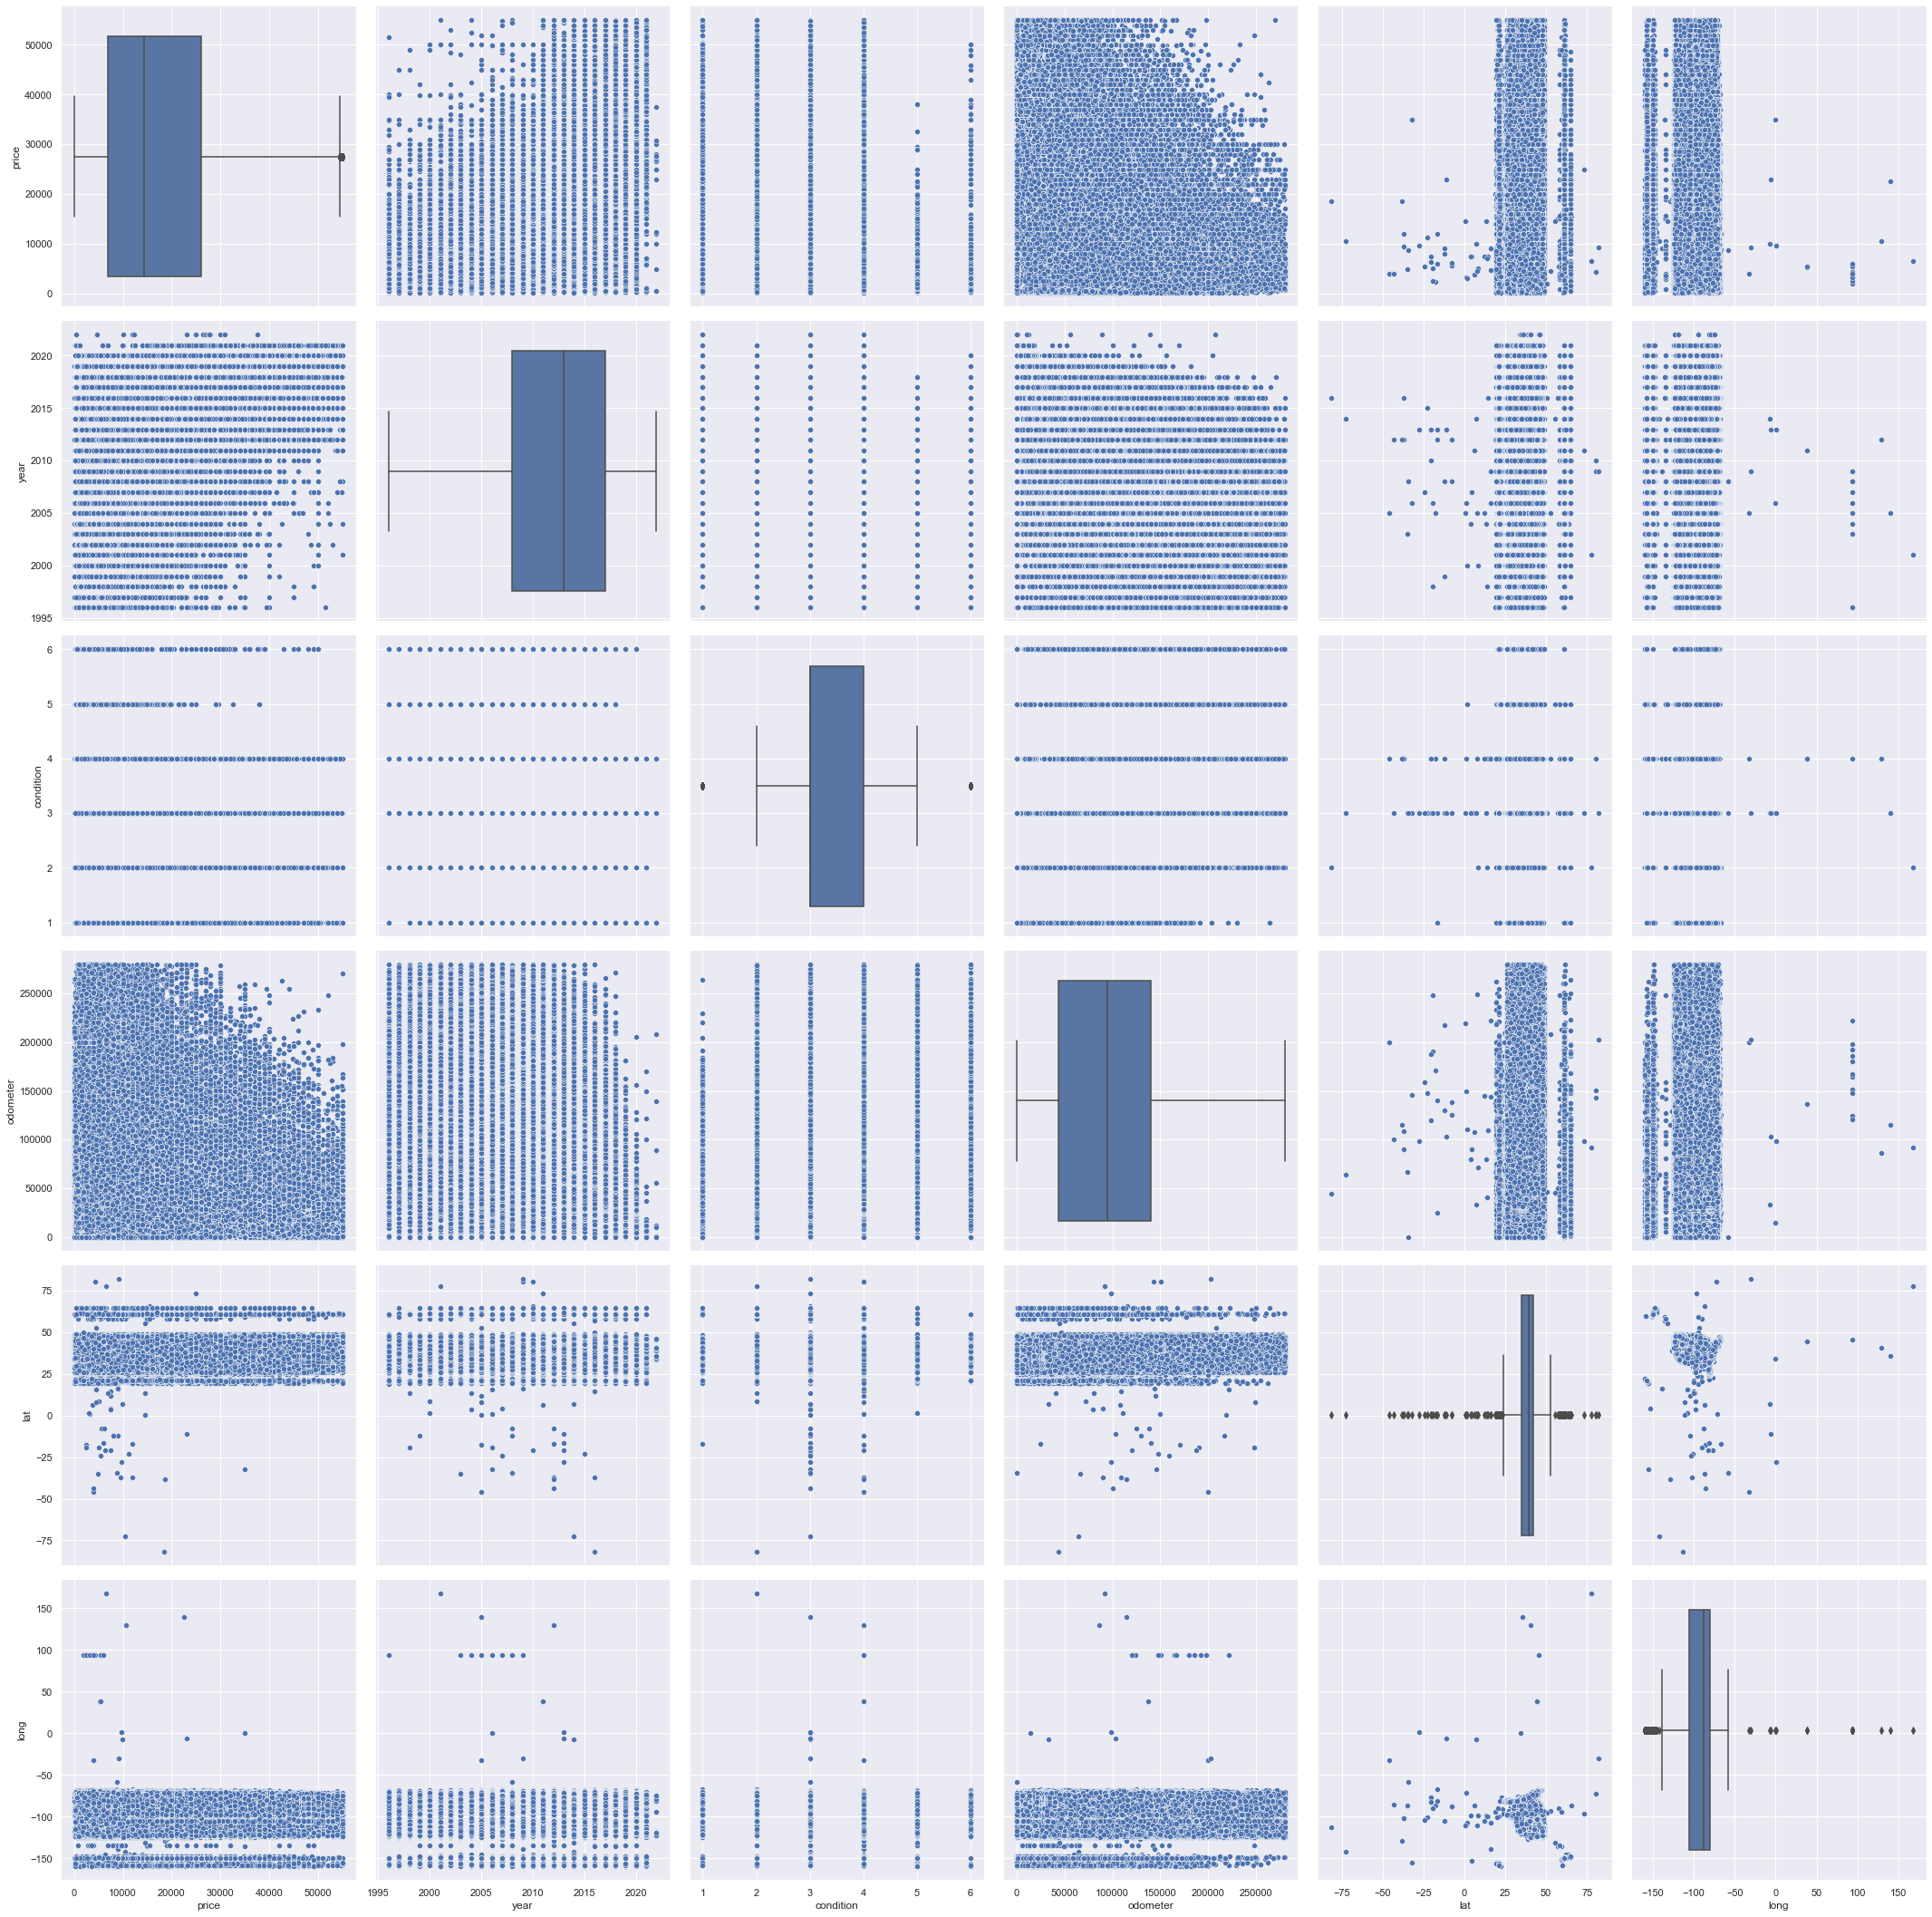

In [192]:
g = sns.PairGrid(df_clean, height=5)
g.map_diag(sns.boxplot)
g.map_offdiag(sns.scatterplot)

In [193]:
#fig = px.histogram(df_clean, marginal="violin", x="odometer",log_y=True, nbins=50, title="Distribution of Odometers counts")
#fig.update_layout(bargap=0.2)
#fig.update_layout(title_x=0.5)
#fig.show()

In [194]:
#fig = px.histogram(df_clean, marginal="violin", x="price", log_y=True, nbins=50, title="Distribution of Prices")
#fig.update_layout(bargap=0.2)
#fig.update_layout(title_x=0.5)
#fig.show()

In [195]:
#fig = px.histogram(df_clean, marginal="violin", x="year", log_y=True, nbins=20, title="Distribution of Prices")
#fig.update_layout(bargap=0.2)
#fig.update_layout(title_x=0.5)
#fig.show()

In [196]:
sns.set(rc={'figure.figsize':(13,8)})

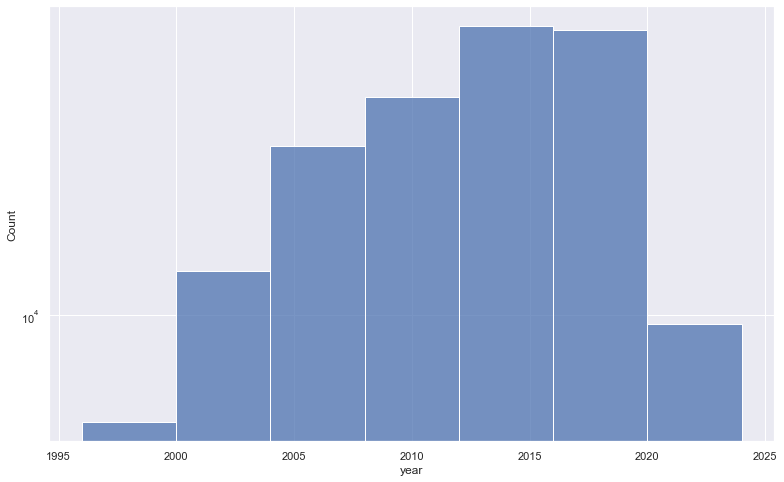

In [197]:
ax = sns.histplot(data=df_clean, x="year", binwidth=4)
ax.set_yscale('log')

<AxesSubplot:xlabel='price', ylabel='Count'>

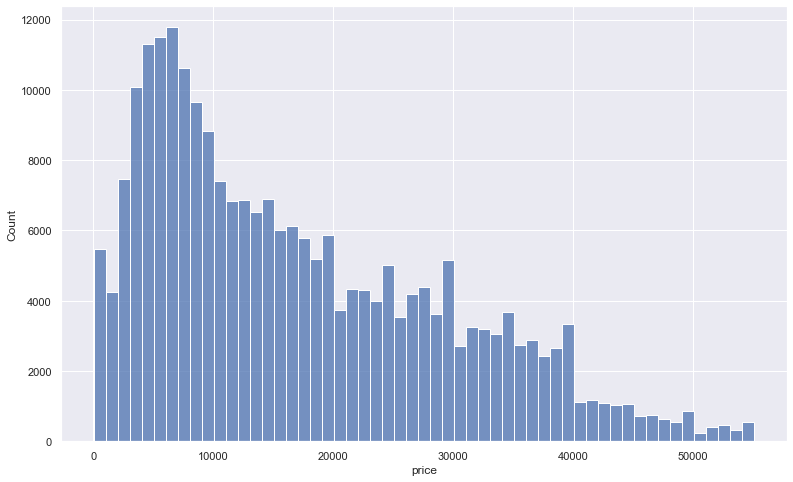

In [198]:
sns.histplot( x=df_clean["price"], binwidth=1000)


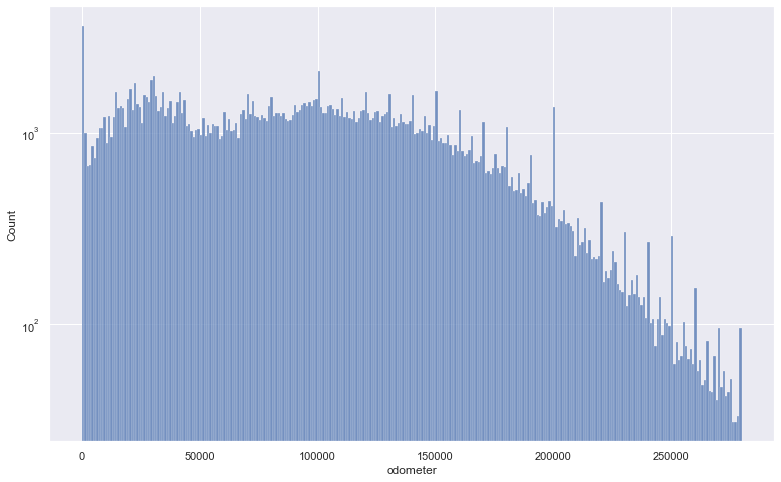

In [199]:
ax = sns.histplot(data=df_clean, x="odometer", binwidth=1000)
ax.set_yscale('log')

In [200]:
df_state = df_clean.groupby(by = ['state'])['region'].count().reset_index().sort_values(by = "region", ascending=False)
df_state.rename(columns={"region":"count"}, inplace=True)
df_state["state"] = df_state["state"].str.upper()

fig = px.choropleth(locations=df_state["state"], locationmode="USA-states", color=df_state["count"],
                    scope="usa", title="Cars Locations (States)")
fig.update_layout(title_x=0.5)
fig.show()

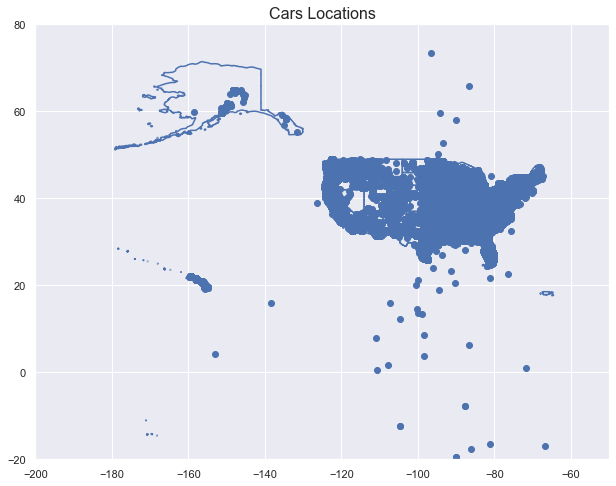

In [201]:
states = geopandas.read_file('./data/tl_2021_us_state.shx')

states.boundary.plot(figsize=(15,8))
plt.title('Cars Locations', fontsize=16)
plt.xlim([-200, -50])
plt.ylim([-20,80])
plt.scatter(x = df_clean['long'], y = df_clean['lat'], marker = "o")


In [202]:
df_clean[["lat", "long"]].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,lat,long
count,237733.000000,237733.000000
mean,38.475805,-93.475265
std,5.716719,17.660319
min,-81.838232,-159.707445
1%,25.909860,-149.865983
5%,28.138400,-122.371376
25%,34.830000,-105.264650
50%,39.337094,-87.633814
75%,42.340777,-80.640000
95%,46.553190,-72.920000


In [203]:
to_drop = df_clean[(df_clean["lat"] <25.909800) | (df_clean["lat"] > 48.754800) |
          (df_clean["long"] <-149.865983) | (df_clean["long"] > -71.064426)]
# to_drop
# df_clean.drop(to_drop.index, inplace = True, axis = 0)

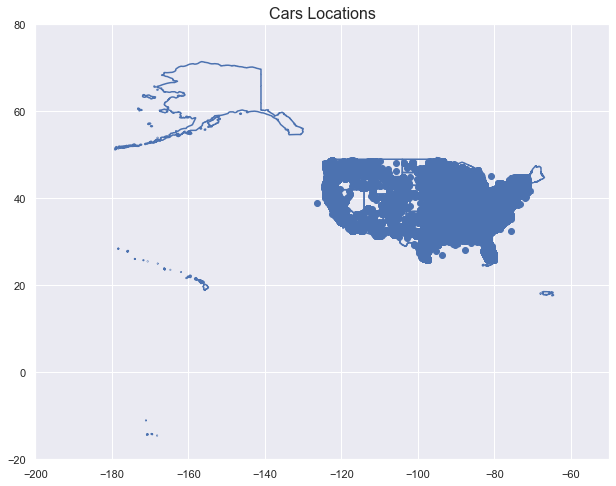

In [204]:
states.boundary.plot(figsize=(15,8))
plt.title('Cars Locations', fontsize=16)

plt.xlim([-200, -50])
plt.ylim([-20,80])

# plt.xlim([-130, -60])
# plt.ylim([20, 60])
plt.scatter(x = df_clean.drop(to_drop.index, axis = 0)['long'], y = df_clean.drop(to_drop.index, axis = 0)['lat'], marker = "o")

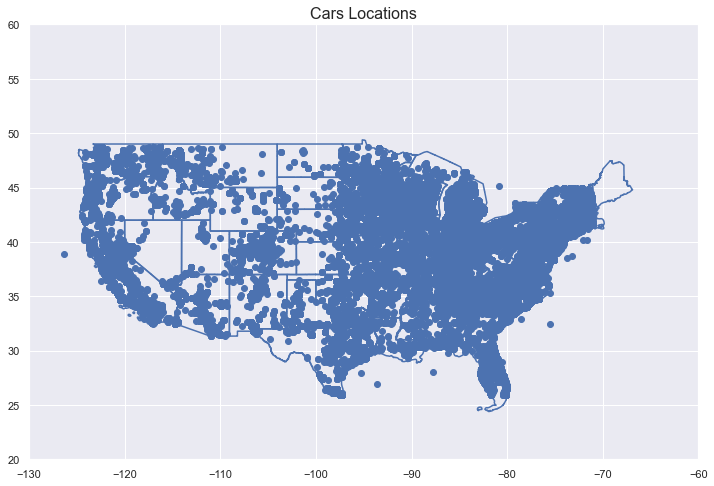

In [205]:
states.boundary.plot(figsize=(15,8))
plt.title('Cars Locations', fontsize=16)

# plt.xlim([-200, -50])
# plt.ylim([-20,80])

plt.xlim([-130, -60])
plt.ylim([20, 60])
plt.scatter(x = df_clean.drop(to_drop.index, axis = 0)['long'], y = df_clean.drop(to_drop.index, axis = 0)['lat'], marker = "o")

In [206]:
manufacturers = df_clean.groupby('manufacturer')['region'].count().reset_index().sort_values(by = "region", ascending=False)
manufacturers.rename(columns={"region":"count"}, inplace=True)
sum_man = int(round(manufacturers["count"].head(10).sum()/manufacturers["count"].sum()*100, 0))

fig = px.pie(manufacturers, values='count',  
             title= "<b>Manufacturers Share</b><br>(Top 10 Manufacturers account for about {}%)" .format(sum_man),
             names="manufacturer")
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize = 15.3, uniformtext_mode='hide')
fig.update_layout(title_x=0.5)
fig.show()


In [207]:
u1p_sum = manufacturers[manufacturers["count"] < sum(manufacturers["count"])/100]["count"].sum()
u1p_cnt = manufacturers[manufacturers["count"] < sum(manufacturers["count"])/100]["manufacturer"].nunique()
u1p_acc = round(10980/sum(manufacturers["count"]),4)
print("Summary of cars manufacturers with listings shares less than 1%\n\n" +
      tabulate([(u1p_cnt, u1p_sum, u1p_acc*100)], headers= ["Sum", "Count", "Accumulated Share"]))

Summary of cars manufacturers with listings shares less than 1%

  Sum    Count    Accumulated Share
-----  -------  -------------------
   14     9961                 4.62


In [208]:
# Deleting manufacturers with cars share of less than 1%
to_drop = manufacturers[manufacturers["count"] < sum(manufacturers["count"])/100]["manufacturer"].unique()
df_clean = df_clean[~df_clean["manufacturer"].isin(to_drop)]

# Number of Manfucaturers left 
df_clean["manufacturer"].nunique()

24

In [209]:
#fig = px.bar(manufacturer_10, x="manufacturer", y="count", color="manufacturer", title="Top 10 manufacturers")
#fig.update_layout(title_x=0.5)

In [210]:
def plot_types(df):
    col_names = ["condition", "cylinders", "drive", "fuel", "title_status", "transmission", "type"]
    names = ["condition", "title_status", "cylinders", "transmission",  "drive", "type", "fuel"] 

    fig = make_subplots(
        rows = 4, cols = 2,
        subplot_titles=(names),
         specs=[[{"type": "domain"}, {"type": "domain"}],
                [{"type": "domain"}, {"type": "domain"}],
                [{"type": "domain"}, {"type": "domain"}],
                [{"type": "domain"}, {"type": "domain"}]])

    for i in range (len(col_names)):
        df_count = df.groupby(col_names[i])[['region']].count().reset_index().rename(columns={"region":"count"})
        df_count = df_count.sort_values(by = 'count')
        labels = df_count.iloc[:, 0]
        values = df_count.iloc[:, 1]

        if i < 4:
            fig.add_trace(go.Pie(values = values, labels = labels), row=i+1, col=1)
        elif i >= 4:
            fig.add_trace(go.Pie(values = values, labels = labels), row=i-3, col=2)



    fig.update_layout(height=1500, width=1000,
                      title_text="Shares in cars")

    fig.update_layout(title_x=0.5)
    fig.update_traces(textposition='inside')
    fig.show()

In [211]:
plot_types(df_clean)

In [212]:
df_clean.groupby("condition").agg({"price":"mean", "odometer":"mean"})

,price,odometer
condition,,
1.0,21149.203960,58360.476562
2.0,17743.339363,82812.632812
3.0,16250.971257,102389.750000
4.0,20256.996505,87092.460938
5.0,3674.805635,171124.937500
6.0,8822.607889,134833.828125


In [213]:
# Deleting all features with shares less than 1%
df_clean = df_clean[~df_clean["condition"].isin([1, 6])]
df_clean = df_clean[df_clean["cylinders"].isin(["6 cylinders", "4 cylinders", "8 cylinders"])]
#df_clean = df_clean[~df_clean["fuel"].isin(["electric"])]
df_clean = df_clean[~df_clean["type"].isin(["offroad", "bus"])]
df_clean = df_clean[~df_clean["title_status"].isin(["lien", "missing", "parts only"])]

df_clean.replace(["electric", "hybrid"], ["electric_or_hybrid", "electric_or_hybrid"], inplace = True)

In [214]:
plot_types(df_clean)

In [215]:
models_dist(df_clean).sort_values("count", ascending =False).head(10).sort_values("share of total (cum)").head(5)

,model,count,quintile (cum),share of total (cum)
990,explorer,1796,99.665924,89.202532
321,altima,1906,99.703044,90.065026
2147,silverado,1967,99.740163,90.955124
951,escape,1973,99.777283,91.847937
585,civic,2108,99.814402,92.801839


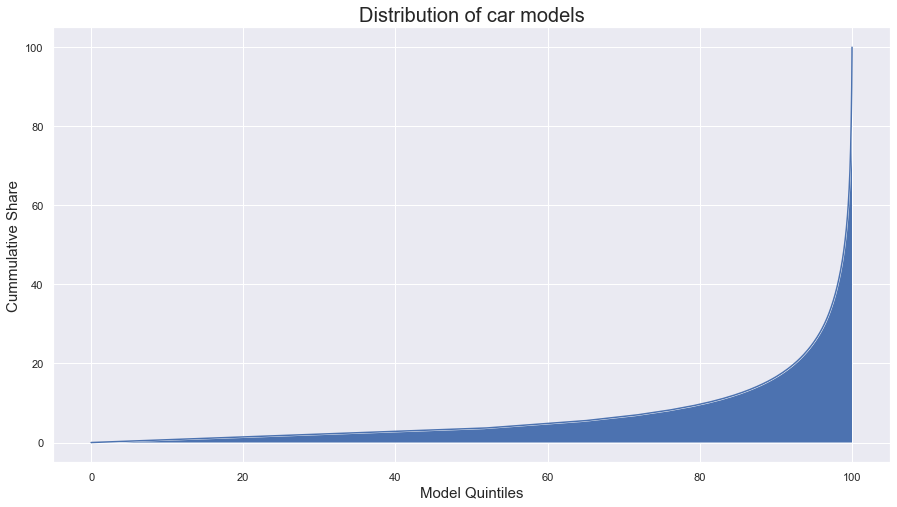

In [216]:
models_plot(models_dist(df_initial))

In [217]:
print("length of initial dataset:", len(df_initial))
print("Number of models in the initial dataset:", df_initial["model"].nunique()) 

length of initial dataset: 426880
Number of models in the initial dataset: 29667


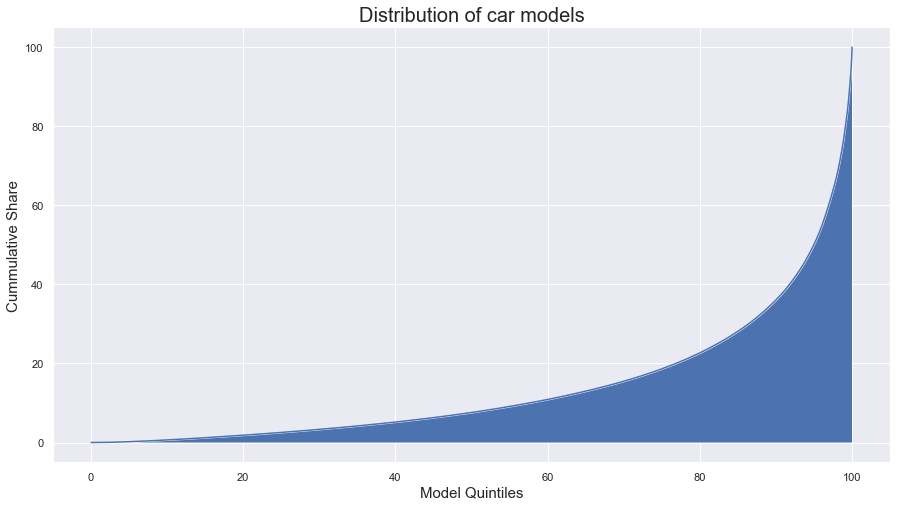

In [218]:
models_plot(models_dist(df_clean))

In [219]:
print("length of clean dataset:", len(df_clean))
print("Number of models in the clean dataset:", df_clean["model"].nunique()) 

length of clean dataset: 220987
Number of models in the clean dataset: 2694


## Preparing Splits

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import math
from sklearn import metrics
import graphviz 

In [83]:
# For the top ten models

#model_names = models_dist(df_clean).sort_values("count", ascending =False).head(50)["model"].unique()
df_models = df_clean.copy(deep= True)

In [86]:
df_models.head(1)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,state,lat,long
135977,spokane / coeur d'alene,18995,2013.0,bmw,128i,3.0,6 cylinders,gas,40443.0,clean,automatic,fwd,coupe,id,47.699801,-116.791144


In [87]:
drop_col = [0, 1, 4, 13]

X = np.delete(df_models.values, drop_col, 1) 
y = df_models.iloc[:, 1].values

df_dtype = pd.DataFrame(df_models.drop(columns=df_models.iloc[:, (drop_col)].columns).dtypes)\
            .reset_index().rename(columns={0:"dtype"})

# Getting categorical and numeric columns numbers

cat_col = df_dtype[((df_dtype.dtype !="float32") & (df_dtype.dtype !="float64")) ].index.values
num_col = df_dtype[((df_dtype.dtype =="float32") | (df_dtype.dtype =="float64")) ].index.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


labels = pd.get_dummies(df_models.drop(df_models.columns[drop_col], axis =1)).columns


ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), cat_col),
                                      ('scaler', StandardScaler(), num_col)],
                       sparse_threshold=0,   remainder = 'passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

## Different Predicting Methods

In [88]:
def model_eval(y_actual, y_pred, name):
    
    index = []
    scores = {"MSE": [], "RMSE": [], 
          "MASE": [], "RE" :[], "R2_squared": []} 
    
    index += [name]
    
    scores["MSE"].append(round(metrics.mean_squared_error(y_actual, y_pred),2))
    scores["RMSE"].append(round(math.sqrt(metrics.mean_squared_error(y_actual, y_pred)),2))
    scores["MASE"].append(round(metrics.mean_absolute_error(y_actual, y_pred),2))
    scores["RE"].append(round(metrics.mean_absolute_error(y_actual, y_pred)*len(y_actual)/sum(abs(y_actual)), 4))
    scores["R2_squared"].append(round(metrics.explained_variance_score(y_actual, y_pred),2))

    df_scores = pd.DataFrame(scores, index=index)
                        
    return df_scores

### Baseline Average Price

In [89]:
baseline = pd.DataFrame(y_test, columns={"actual"})
baseline["prediction"] = mean(y_train)

baseline = model_eval(baseline["actual"], baseline["prediction"], "Avg Price Model")
baseline

,MSE,RMSE,MASE,RE,R2_squared
Avg Price Model,1.520253e+08,12329.85,10315.25,0.5879,0.0


### Simple Linear Regression

In [90]:
LR = LinearRegression().fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)

LR_model = model_eval(y_test, y_pred_LR, "Linear Regression")
LR_model

,MSE,RMSE,MASE,RE,R2_squared
Linear Regression,40114594.07,6333.61,4411.77,0.2514,0.74


### Decision Tree

In [91]:
# Simple Model
DTR = DecisionTreeRegressor(random_state=0)
DTR.fit(X_train, y_train)
y_pred_DTR = DTR.predict(X_test)

DTR_model = model_eval(y_test, y_pred_DTR, "Decision Tree Regressor default")
DTR_model

,MSE,RMSE,MASE,RE,R2_squared
Decision Tree Regressor default,28549410.52,5343.16,2504.32,0.1427,0.81


In [92]:
DTR = DecisionTreeRegressor(max_depth=30, min_samples_leaf=2, random_state=0)
DTR.fit(X_train, y_train)
y_pred_DTR = DTR.predict(X_test)

DTR_model_tuned = model_eval(y_test, y_pred_DTR, "Decision Tree Regressor tuned")
DTR_model_tuned

,MSE,RMSE,MASE,RE,R2_squared
Decision Tree Regressor tuned,25911904.36,5090.37,2614.45,0.149,0.83


### Random Forest

In [97]:
RFregressor = RandomForestRegressor(random_state=0, n_jobs= -1)
RFregressor.fit(X_train, y_train)
y_pred_RFR = RFregressor.predict(X_test)

RFR_model = model_eval(y_test, y_pred_RFR, "Random Forest Regressor default")
RFR_model

,MSE,RMSE,MASE,RE,R2_squared
Random Forest Regressor default,15382114.75,3922.0,1994.6,0.1137,0.9


In [104]:
RFregressor = RandomForestRegressor(n_estimators=200, max_features=0.25, random_state=0, n_jobs= -1)
RFregressor.fit(X_train, y_train)
y_pred_RFR = RFregressor.predict(X_test)

RFR_model_tuned = model_eval(y_test, y_pred_RFR, "Random Forest Regressor tuned")
RFR_model_tuned

,MSE,RMSE,MASE,RE,R2_squared
Random Forest Regressor tuned,14022573.61,3744.67,1915.6,0.1092,0.91


### XGBooster

In [99]:
xgb = XGBRegressor(random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_model = model_eval(y_test, y_pred_xgb, "XGBRegressor default")
xgb_model

,MSE,RMSE,MASE,RE,R2_squared
XGBRegressor default,17136025.11,4139.57,2695.31,0.1536,0.89


Best: -3732.507938 using {'learning_rate': 0.3, 'n_estimators': 1000}
-3901.288247 (36.650144) with: {'learning_rate': 0.2, 'n_estimators': 500}
-3780.538308 (38.040395) with: {'learning_rate': 0.2, 'n_estimators': 800}
-3736.607765 (36.970782) with: {'learning_rate': 0.2, 'n_estimators': 1000}
-3853.495359 (30.039354) with: {'learning_rate': 0.3, 'n_estimators': 500}
-3763.652624 (26.976168) with: {'learning_rate': 0.3, 'n_estimators': 800}
-3732.507938 (27.522621) with: {'learning_rate': 0.3, 'n_estimators': 1000}


Text(0, 0.5, 'Log Loss')

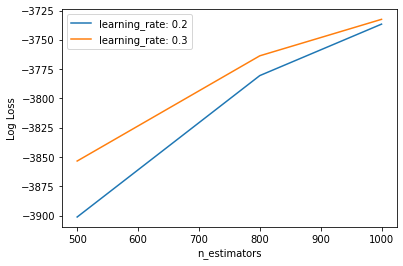

In [106]:
xgb = XGBRegressor(tree_method = "gpu_hist", random_state = 0) # max_bin = 300,

n_estimators = [500, 800, 1000]
learning_rate = [0.2, 0.3]
#max_bin = [500, 1000, 5000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

#y_pred_xgb = grid_result.predict(X_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
#plt.savefig('n_estimators_vs_learning_rate.png')

In [110]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate = 0.3, tree_method = "gpu_hist", random_state = 0) # max_bin = 300,

max_depth = [6, 8, 10]
# gamma = [1, 5, 10]
# reg_lambda = [1, 5, 10]
max_bin = [500, 1000, 5000]
param_grid = dict(max_depth = max_depth, max_bin = max_bin)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

#y_pred_xgb = grid_result.predict(X_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: -3368.351084 using {'max_bin': 5000, 'max_depth': 8}
-3621.001207 (18.311931) with: {'max_bin': 500, 'max_depth': 6}
-3560.845626 (30.406793) with: {'max_bin': 500, 'max_depth': 8}
-3589.495188 (26.204962) with: {'max_bin': 500, 'max_depth': 10}
-3555.001803 (16.417482) with: {'max_bin': 1000, 'max_depth': 6}
-3477.007006 (25.599052) with: {'max_bin': 1000, 'max_depth': 8}
-3521.831687 (5.324980) with: {'max_bin': 1000, 'max_depth': 10}
-3422.966846 (17.022117) with: {'max_bin': 5000, 'max_depth': 6}
-3368.351084 (11.658023) with: {'max_bin': 5000, 'max_depth': 8}
-3409.592852 (24.944737) with: {'max_bin': 5000, 'max_depth': 10}


In [111]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate = 0.3, max_depth = 8, max_bin = 5000,
                   tree_method = "gpu_hist", random_state = 0) 

gamma = [1, 5, 10]
reg_lambda = [1, 5, 10]

param_grid = dict(gamma = gamma, reg_lambda = reg_lambda)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

#y_pred_xgb = grid_result.predict(X_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: -3328.266787 using {'gamma': 10, 'reg_lambda': 5}
-3358.983925 (40.106503) with: {'gamma': 1, 'reg_lambda': 1}
-3331.767164 (28.131210) with: {'gamma': 1, 'reg_lambda': 5}
-3332.335176 (18.627038) with: {'gamma': 1, 'reg_lambda': 10}
-3358.983920 (40.106495) with: {'gamma': 5, 'reg_lambda': 1}
-3329.801437 (25.454042) with: {'gamma': 5, 'reg_lambda': 5}
-3332.763223 (18.468214) with: {'gamma': 5, 'reg_lambda': 10}
-3355.218081 (38.153097) with: {'gamma': 10, 'reg_lambda': 1}
-3328.266787 (28.136841) with: {'gamma': 10, 'reg_lambda': 5}
-3331.598481 (18.986327) with: {'gamma': 10, 'reg_lambda': 10}


In [121]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate= 0.3, max_depth = 8, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_model_tuned = model_eval(y_test, y_pred_xgb, "XGBRegressor tuned")
xgb_model_tuned

,MSE,RMSE,MASE,RE,R2_squared
XGBRegressor tuned,10011469.51,3164.09,1864.47,0.1063,0.93


In [140]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate= 0.30, max_depth = 9, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_model_tuned = model_eval(y_test, y_pred_xgb, "XGBRegressor tuned")
xgb_model_tuned

,MSE,RMSE,MASE,RE,R2_squared
XGBRegressor tuned,9774162.26,3126.37,1793.7,0.1022,0.94


In [142]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate= 0.3, max_depth = 10, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

model_eval(y_test, y_pred_xgb, "XGBRegressor tuned")

,MSE,RMSE,MASE,RE,R2_squared
XGBRegressor tuned,9925772.86,3150.52,1762.26,0.1004,0.93


### Summary

In [141]:
pd.concat([baseline, LR_model, DTR_model, DTR_model_tuned, RFR_model, RFR_model_tuned, xgb_model, xgb_model_tuned])

,MSE,RMSE,MASE,RE,R2_squared
Avg Price Model,1.520253e+08,12329.85,10315.25,0.5879,0.00
Linear Regression,4.011459e+07,6333.61,4411.77,0.2514,0.74
Decision Tree Regressor default,2.854941e+07,5343.16,2504.32,0.1427,0.81
Decision Tree Regressor tuned,2.591190e+07,5090.37,2614.45,0.1490,0.83
Random Forest Regressor default,1.538211e+07,3922.00,1994.60,0.1137,0.90
Random Forest Regressor tuned,1.402257e+07,3744.67,1915.60,0.1092,0.91
XGBRegressor default,1.713603e+07,4139.57,2695.31,0.1536,0.89
XGBRegressor tuned,9.774162e+06,3126.37,1793.70,0.1022,0.94


In [101]:
pd.concat([baseline, LR_model, DTR_model, DTR_model_tuned, RFR_model, RFR_model_tuned, xgb_model, xgb_model_tuned])

,MSE,RMSE,MASE,RE,R2_squared
Avg Price Model,1.520253e+08,12329.85,10315.25,0.5879,0.00
Linear Regression,4.011459e+07,6333.61,4411.77,0.2514,0.74
Decision Tree Regressor default,2.854941e+07,5343.16,2504.32,0.1427,0.81
Decision Tree Regressor tuned,2.591190e+07,5090.37,2614.45,0.1490,0.83
Random Forest Regressor default,1.538211e+07,3922.00,1994.60,0.1137,0.90
Random Forest Regressor tuned,1.404140e+07,3747.19,1917.90,0.1093,0.91
XGBRegressor default,1.713603e+07,4139.57,2695.31,0.1536,0.89
XGBRegressor tuned,1.144012e+07,3382.32,1854.99,0.1057,0.92


Best: -3574.500762 using {'learning_rate': 0.3, 'n_estimators': 500}
-4772.727794 (37.203300) with: {'learning_rate': 0.1, 'n_estimators': 100}
-4176.004231 (37.048658) with: {'learning_rate': 0.1, 'n_estimators': 300}
-3928.216018 (42.145094) with: {'learning_rate': 0.1, 'n_estimators': 500}
-4387.279140 (27.849973) with: {'learning_rate': 0.2, 'n_estimators': 100}
-3835.313357 (54.868235) with: {'learning_rate': 0.2, 'n_estimators': 300}
-3642.673843 (47.420087) with: {'learning_rate': 0.2, 'n_estimators': 500}
-4174.488323 (52.849308) with: {'learning_rate': 0.3, 'n_estimators': 100}
-3738.491216 (52.723886) with: {'learning_rate': 0.3, 'n_estimators': 300}
-3574.500762 (44.043557) with: {'learning_rate': 0.3, 'n_estimators': 500}


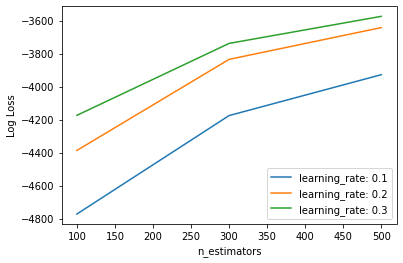

In [113]:
model = XGBRegressor(n_jobs=-1)

n_estimators = [100,  300,  500]
learning_rate = [0.1, 0.2, 0.3]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
                              
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

In [134]:
model = XGBRegressor(tree_method = "gpu_hist", random_state = 0) # max_bin = 300,

n_estimators = [700, 800, 1000]
learning_rate = [0.2, 0.3]
max_bin = [1000, 2000, 3000, 5000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_bin = max_bin)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
                              
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
#plt.savefig('n_estimators_vs_learning_rate.png')

Best: -3438.110455 using {'learning_rate': 0.3, 'max_bin': 5000, 'n_estimators': 1000}
-3644.373843 (26.930268) with: {'learning_rate': 0.2, 'max_bin': 1000, 'n_estimators': 700}
-3609.976496 (25.599598) with: {'learning_rate': 0.2, 'max_bin': 1000, 'n_estimators': 800}
-3563.172487 (21.956507) with: {'learning_rate': 0.2, 'max_bin': 1000, 'n_estimators': 1000}
-3602.665547 (25.978416) with: {'learning_rate': 0.2, 'max_bin': 2000, 'n_estimators': 700}
-3565.596024 (27.233012) with: {'learning_rate': 0.2, 'max_bin': 2000, 'n_estimators': 800}
-3515.439984 (30.397351) with: {'learning_rate': 0.2, 'max_bin': 2000, 'n_estimators': 1000}
-3572.078948 (20.175591) with: {'learning_rate': 0.2, 'max_bin': 3000, 'n_estimators': 700}
-3535.769836 (21.937530) with: {'learning_rate': 0.2, 'max_bin': 3000, 'n_estimators': 800}
-3482.505061 (26.782348) with: {'learning_rate': 0.2, 'max_bin': 3000, 'n_estimators': 1000}
-3561.200741 (19.761672) with: {'learning_rate': 0.2, 'max_bin': 5000, 'n_estimato

ValueError: cannot reshape array of size 24 into shape (2,3)